In [1]:
!pip install /kaggle/input/segmentation-models-wheels/timm-0.6.12-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/efficientnet_pytorch-0.7.1-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/segmentation_models_pytorch-0.3.2-py3-none-any.whl

Processing /kaggle/input/segmentation-models-wheels/timm-0.6.12-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 KB 9.8 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/efficientnet_pytorch-0.7.1-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/segmentation_models_pytorch-0.3.2-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
# basic modules
import pandas as pd
import numpy as np
import datetime
import os
from tqdm import tqdm
from datetime import datetime
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython import display

# pytorch modules
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torchvision.transforms import Normalize
from torch.multiprocessing import Pool

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from collections import OrderedDict
from torch.optim import lr_scheduler

from timm.scheduler import CosineLRScheduler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import segmentation_models_pytorch as smp

In [4]:
import torch_xla
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp

In [5]:
base_dir = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/"
train_path = os.path.join(base_dir,"train")
test_path = os.path.join(base_dir,"test")
val_path = os.path.join(base_dir,"validation")

train_ids = os.listdir(train_path)
#train_ids = np.loadtxt("/kaggle/input/train-ids-existcontrail/train_ids_ExistContrail.csv", delimiter=",", dtype = "unicode")
#train_ids = train_ids.tolist()

test_ids = os.listdir(test_path)
val_ids = os.listdir(val_path)

In [6]:
def ash_transform(x, time_frame:int=4):
    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)
    if time_frame is not None:
        x = x[:,time_frame,:,:]
    def normalize_range(data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    r = normalize_range(x[2] - x[1], _TDIFF_BOUNDS)
    g = normalize_range(x[1] - x[0], _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(x[1], _T11_BOUNDS)
    
    return np.clip(np.stack([r, g, b], axis=-3), 0, 1) # (T,3,H,W) or (3,H,W)

In [7]:
def random_horizontal_flip(video):
    horizontal = random.random()
    if horizontal < 0.5:
        return video[..., ::-1], horizontal
    return video, horizontal

def random_vertical_flip(video):
    vertical = random.random()
    if vertical < 0.5:
        return video[..., ::-1, :], vertical
    return video, vertical

def random_mask(img, mask_size=10, musk_num=20):
    i = 0
    for i in range(musk_num):
        if random.random() < 0.5:
            h, w = img.shape[-2:]
            top = random.randint(0, h - mask_size)
            left = random.randint(0, w - mask_size)
            img[..., top:top+mask_size, left:left+mask_size] = 0
            i += 1
    return img

def augment_video(video):
    #video = random_vertical_flip(video)  #正解データも反転させないとダメでは？
    #print(video.shape)
    video = np.stack([random_mask(frame) for frame in video.transpose(1, 0, 2, 3)])

    return video.transpose(1, 0, 2, 3)


# Test with dummy data
#video = np.random.rand(3, 10, 224, 224)
#augmented_video = augment_video(video)

In [8]:
class ContrailDataset(Dataset):
    def __init__(self, ids, base_dir, bands=None, transforms:list=[], test_mode:bool=False, aug=False):
        self.ids = ids
        self.base_dir = base_dir
        self.transforms = transforms
        self.bands = bands
        self.permute = (2,0,1)
        self.test_mode = test_mode
        self.aug = aug
        
    def __getitem__(self, index):
        record_id = self.ids[index]
        
        if self.bands is None:
            band_list = [f'band_{band:02d}.npy' for band in range(8,17)]
        else :
            band_list = [f'band_{int(band):02d}.npy' for band in self.bands]
        
        x = list()
        for band in band_list:
            x_path = os.path.join(self.base_dir, record_id, band)
            x.append(np.load(x_path).transpose(self.permute))

        x = np.stack(x,axis=1) ## X.shape = (Time_frame,channel,H,W)
        
        x = x.transpose((1,0,2,3)) ## PLUS ## X.shape = (channel, Time_frame ,H,W)
        
        #print(x.shape)
        for transformation in self.transforms:
            x = transformation(x) #c, H, W
            
        if self.test_mode==False:
            y_path = os.path.join(self.base_dir, record_id,'human_pixel_masks.npy')
            y = np.load(y_path).transpose(self.permute)
            x = np.concatenate((x, y), axis=0)
        
        if self.aug:
            #print(x.shape)
            #x,hor = random_horizontal_flip(x)
            #x,ver = random_vertical_flip(x)
            #x = augment_video(x)
            x = random_mask(x)
        
        x = torch.from_numpy(x.astype(np.float32))
        
        x = T.transforms.Resize(384)(x)
        
        if self.aug:
            x = T.RandomHorizontalFlip(0.3)(x)
            x = T.RandomVerticalFlip(0.1)(x)
            x = T.RandomRotation(20)(x)

        return x

    def __len__(self):
        return len(self.ids)
        

In [9]:
os.cpu_count()

96

In [10]:
# Datasets 
dataset_params = {
    "bands" : [11,14,15], 
    "transforms" : [ash_transform]
}
train_dataset = ContrailDataset(train_ids, train_path, **dataset_params, aug=True)
test_dataset = ContrailDataset(test_ids, test_path, test_mode=True, **dataset_params)
val_dataset = ContrailDataset(val_ids, val_path, **dataset_params)

# DalaLoaders
dataloader_params = {
    "batch_size" : 16,
    "shuffle" : True,
    "num_workers": 20,
    "drop_last": True
#     "pin_memory": True

}
train_loader = DataLoader(train_dataset, **dataloader_params)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=2)
val_loader = DataLoader(val_dataset, **dataloader_params)

In [11]:
def plot_contrail(x, time_frame = 4):
    '''
    x = false color img of shape (8, 3, H, W)
    y = contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
        
    y = x.permute(1,2,0)[:,:,3]
    print(x.permute(1,2,0)[:,:,0:3].shape)
    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(x.permute(1,2,0)[:,:,0:3])
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(y, interpolation='none')
    ax.set_title('Ground truth contrail mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(x.permute(1,2,0)[:,:,0:3])
    ax.imshow(y, cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

    plt.show()

def plot_contrail_comparision(x, y_true, y_pred, time_frame = 4):
    '''
    x = false color img of shape (3, H, W) or (8, 3, H, W)
    y_true = target contrail mask of shape (1, H, W)
    y_pred = predicted contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]

    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 5, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image(x)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 2)
    ax.imshow(y_true.permute(1,2,0), interpolation='none')
    ax.set_title('True contrail mask(y_true)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_true.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_true mask on x')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 4)
    ax.imshow(y_pred.permute(1,2,0), interpolation='none')
    ax.set_title('Pred contrail mask(y_pred)')
    ax.axis('off')

    ax = plt.subplot(1, 5, 5)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_pred.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_pred mask on x')
    ax.axis('off')
    
    plt.show()

def animate_contrail(x):
    '''
    x = false color img of shape (8, 3, H, W)
    '''
    if x.ndim !=4:
        print(f"Incorrect input dimensions, Expected 4 recievied {x.ndim}.")
        return
    # Animation
    fig = plt.figure(figsize=(4, 4))
    im = plt.imshow(x[0].permute(1,2,0))
    def draw(i):
        im.set_array(x[i].permute(1,2,0))
        return [im]
    anim = animation.FuncAnimation(
        fig, draw, frames=x.shape[0], interval=100, blit=True
    )
    plt.close()
    return display.HTML(anim.to_jshtml())

/usr/local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([384, 384, 3])


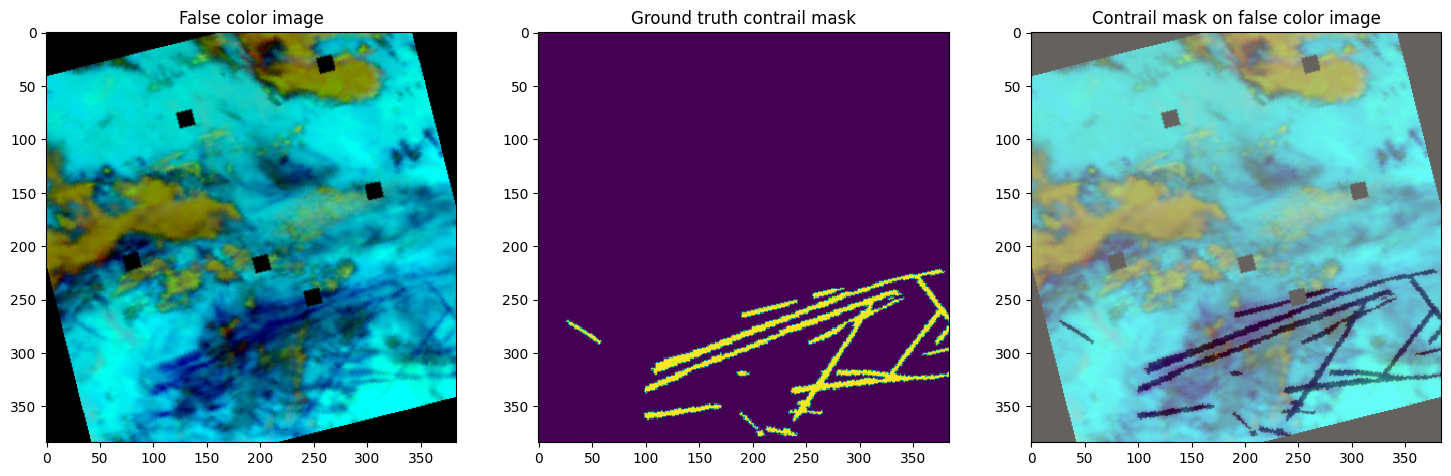

In [12]:
 x = train_dataset[train_ids.index('1704010292581573769')]
 plot_contrail(x)

In [13]:
# old type
'''# Dice Coefficient
def dice_coeff(mask1, mask2):
    intersect = torch.sum(mask1 * mask2)
    m1sum = torch.sum(mask1)
    m2sum = torch.sum(mask2)
    dice = (2 * intersect ) / (m1sum + m2sum)
    return dice.item()
'''

'# Dice Coefficient\ndef dice_coeff(mask1, mask2):\n    intersect = torch.sum(mask1 * mask2)\n    m1sum = torch.sum(mask1)\n    m2sum = torch.sum(mask2)\n    dice = (2 * intersect ) / (m1sum + m2sum)\n    return dice.item()\n'

In [14]:
def dice_coeff(y_p, y_t, smooth=1e-6):
    i = torch.sum(y_p * y_t, dim=(2, 3))
    #u = torch.sum(y_p, dim=(2, 3)) + torch.sum(y_t, dim=(2, 3))
    u = torch.sum(y_p, dim=(2, 3)) + torch.sum(y_t, dim=(1, 2))
    score = (2 * i + smooth)/(u + smooth)
    dice = torch.mean(score)
    return dice.item()

In [15]:
# Callbacks
class History:
    def __init__(self, print_prefix, save_to_disk=True):
        self.train_batch_history = []
        self.val_batch_histroy = []
        self.train_epoch_history = []
        self.val_epoch_history = []
        self.running_train_batch_history = []
        self.running_val_batch_history = []
        self.print_prefix = print_prefix
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states",self.print_prefix)
            if not os.path.exists(self.save_path):
                os.makedirs(self.save_path)
    def on_train_batch_end(self, data):
        self.running_train_batch_history.append(data)
        
    def on_val_batch_end(self, data):
        self.running_val_batch_history.append(data)
        
    def on_epoch_end(self):
        self.train_epoch_history.append(np.mean(self.running_train_batch_history))
        self.train_batch_history.extend(self.running_train_batch_history)
        self.running_train_batch_history=[]
        self.val_epoch_history.append(np.mean(self.running_val_batch_history))
        self.val_batch_histroy.extend(self.running_val_batch_history)
        self.running_val_batch_history=[]
        print(f"{self.print_prefix}: Train = {self.train_epoch_history[-1]:.6f} \
        | Val = {self.val_epoch_history[-1]:.6f}")
    
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            np.save(os.path.join(self.save_path,"train_batch.npy"),self.train_batch_history)
            np.save(os.path.join(self.save_path,"val_batch.npy"),self.val_batch_histroy)
            np.save(os.path.join(self.save_path,"train_epoch.npy"),self.train_epoch_history)
            np.save(os.path.join(self.save_path,"val_epoch.npy"),self.val_epoch_history)

In [16]:
class BestStateTracker:
    def __init__(self, model, optim, trigger:History, save_to_disk:bool = False):
        self.trigger = trigger
        self.model = model
        self.optim = optim
        self.optim_state = None
        self.model_state = None
        self.best_loss = np.inf
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states")
            if not os.path.exists(self.save_path):
                os.mkdir(self.save_path)
                
    def on_epoch_end(self):
        if self.trigger.val_epoch_history[-1] < self.best_loss:
            self.model_state = self.model.state_dict()
            self.optim_state = self.optim.state_dict()
            
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            xm.save(self.model_state,os.path.join(self.save_path,f"model_state_end.pt"))
            xm.save(self.optim_state,os.path.join(self.save_path,f"optim_state_end.pt"))

In [17]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, dilations):
        super(ASPP, self).__init__()
        self.aspp_blocks = nn.ModuleList()
        for dilation in dilations:
            self.aspp_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
                )

    def forward(self, x):
        return sum(block(x) for block in self.aspp_blocks)


In [18]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = ASPP(features * 8, features * 16, dilations=[1, 6, 12, 18])

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )
    

In [19]:
device = xm.xla_device()

E0707 09:10:53.644224597     312 oauth2_credentials.cc:236]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {created_time:"2023-07-07T09:10:53.64419295+00:00", grpc_status:2}


In [20]:
model = UNet().to(device)

In [21]:
ENCODER = 'timm-resnest26d' #'resnet101''timm-efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet' #'imagenet''noisy-student'

ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=None,
).to(device)

'''model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)'''

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth" to /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth
100%|██████████| 65.3M/65.3M [00:00<00:00, 136MB/s]


'model = smp.DeepLabV3Plus(\n    encoder_name=ENCODER, \n    encoder_weights=ENCODER_WEIGHTS, \n    classes=1, \n    activation=ACTIVATION,\n).to(device)'

In [22]:
class Focal_MultiLabel_Loss(nn.Module):
    def __init__(self, gamma):
      super(Focal_MultiLabel_Loss, self).__init__()
      self.gamma = gamma
      self.bceloss = nn.BCELoss(reduction='none')

    def forward(self, outputs, targets): 
      outputs = F.sigmoid(outputs)  
      bce = self.bceloss(outputs, targets)
      bce_exp = torch.exp(-bce)
      focal_loss = (1-bce_exp)**self.gamma * bce
      return focal_loss.mean()

In [23]:
!mkdir /kaggle/working/model

In [24]:
LR = 5e-4 #2e-3
EPOCHS = 8

FLAGS={}
FLAGS['num_cores'] = 8
FLAGS['start_epoch'] = 0
FLAGS['num_epochs'] = EPOCHS
FLAGS['num_workers'] = 12
FLAGS['log_steps'] = 100
FLAGS['seed'] = 1234
FLAGS['max_lr'] = LR
FLAGS['min_lr'] = 0.00004
FLAGS['warmup_steps'] = 0

In [25]:
optimizer = Adam(params=model.parameters(), lr=LR)
#loss_fn = BCELoss()
#loss_fn = Focal_MultiLabel_Loss(gamma=2) 

loss_fn = smp.losses.DiceLoss(mode="binary", smooth=1.0)
#loss_fn_2 = smp.losses.FocalLoss(mode="binary")
loss_fn_2 = Focal_MultiLabel_Loss(gamma=2) 

#scheduler = ReduceLROnPlateau(optimizer)
scheduler = CosineLRScheduler(optimizer, 
                              t_initial=EPOCHS, 
                              lr_min=FLAGS['min_lr'], 
                              warmup_t=FLAGS['warmup_steps'],
                              warmup_lr_init=5e-6,
                              warmup_prefix=True)

loss_tracker = History(print_prefix="Loss")
dice_tracker = History(print_prefix="Dice")
save_state = BestStateTracker(model,optimizer,loss_tracker,save_to_disk=True)

In [26]:
WRAPPED_MODEL = xmp.MpModelWrapper(model)


def _map_fn(index, flags):
  pbar = tqdm(range(flags['start_epoch'], flags['num_epochs']))
  loss_best = 1.0
  torch.manual_seed(flags['seed'])

  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  
  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
  train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler=train_sampler,
    num_workers=flags['num_workers'],
    drop_last=True)
  
  val_sampler = torch.utils.data.distributed.DistributedSampler(
    val_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False)

  val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = 16,
    sampler=val_sampler,
    num_workers=flags['num_workers'],
    drop_last=False)

  for epoch in range(flags['start_epoch'], flags['num_epochs']):
    current_lr = optimizer.param_groups[0]['lr']
    xm.master_print(f"EPOCH: {epoch+1}/{flags['num_epochs']}, Learning rate: {current_lr}")
    para_train_loader = pl.ParallelLoader(train_loader, [device])
    model.train()
    
    for idx, data in enumerate(para_train_loader.per_device_loader(device)):
      target = data[:, 3]
      #xm.master_print("target shape is ", target.shape)
      target = target.unsqueeze(1)
      
      data = data[:,0:3]
      #xm.master_print("data shape is ", data.shape)
        
      y_pred = model(data)

      loss = loss_fn(y_pred, target) + loss_fn_2(y_pred, target)
      optimizer.zero_grad()
      loss.backward()
      xm.optimizer_step(optimizer)
      
      if idx % flags['log_steps'] == 0:
        xm.master_print(f'Train Batch: {idx+1}/{len(train_loader)} | Loss: {loss.item():.6f}')
        
      loss_tracker.on_train_batch_end(loss.item())
      dice_tracker.on_train_batch_end(dice_coeff(y_pred>0.5, target))
      #pbar.set_description(f"Train Batch: {idx+1}/{len(train_loader)}\
      #| Loss: {loss.item():.6f}")

    plot_contrail_comparision(data[0].cpu().detach(),
                           target[0].cpu().detach(),
                           y_pred[0].cpu().detach()>0.5)
      
    model.eval()
    para_val_loader = pl.ParallelLoader(val_loader, [device])
    
    with torch.no_grad():
        for idx, data in enumerate(para_val_loader.per_device_loader(device)):
            target = data[:, 3]
            target = target.unsqueeze(1)
            data = data[:,0:3]
            y_pred = model(data)
            loss = loss_fn(y_pred, target)
            loss_tracker.on_val_batch_end(loss.item())
            dice_tracker.on_val_batch_end(dice_coeff(y_pred>0.5, target))
            #pbar.set_description(f"Val Batch:   {idx+1}/{len(val_loader)}\
            #| Loss: {loss.item():.6f}")
            if idx % flags['log_steps'] == 0:
                xm.master_print(f'Val Batch: {idx+1}/{len(val_loader)} | Loss: {loss.item():.6f}')
                
        plot_contrail_comparision(data[0].cpu().detach(),
                        target[0].cpu().detach(),
                        y_pred[0].cpu().detach()>0.5)
    
                
    #xm.save(model.state_dict(), flags['save_path'])    
    scheduler.step(epoch)
    loss_tracker.on_epoch_end()
    dice_tracker.on_epoch_end()
    save_state.on_epoch_end()

  save_state.on_end()
  loss_tracker.on_end()
  dice_tracker.on_end()

  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH: 1/8, Learning rate: 0.0005
Train Batch: 1/1283 | Loss: 1.429106
Train Batch: 101/1283 | Loss: 0.989119
Train Batch: 201/1283 | Loss: 0.921723
Train Batch: 301/1283 | Loss: 0.535807
Train Batch: 401/1283 | Loss: 0.500392
Train Batch: 501/1283 | Loss: 0.647111
Train Batch: 601/1283 | Loss: 0.492274
Train Batch: 701/1283 | Loss: 0.502537
Train Batch: 801/1283 | Loss: 0.569381
Train Batch: 901/1283 | Loss: 0.550611
Train Batch: 1001/1283 | Loss: 0.500544
Train Batch: 1101/1283 | Loss: 0.432031
Train Batch: 1201/1283 | Loss: 0.485677


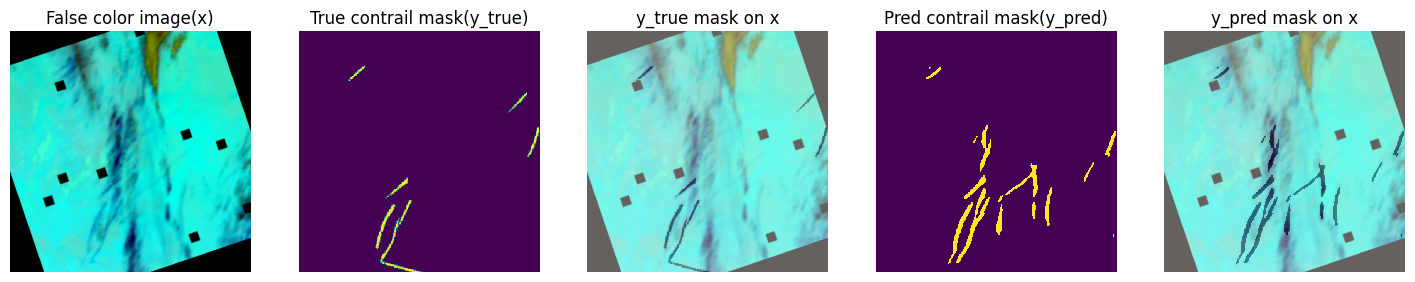

Val Batch: 1/116 | Loss: 0.476885
Val Batch: 101/116 | Loss: 0.463536


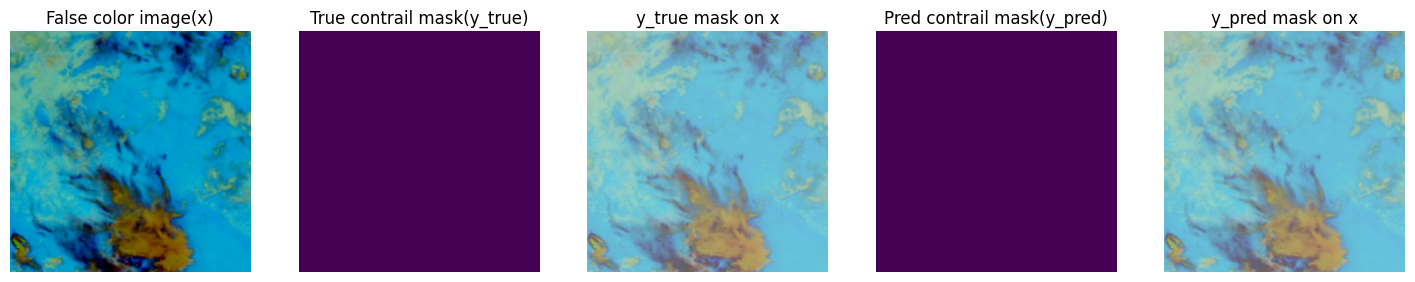

Loss: Train = 0.637534         | Val = 0.565235
Dice: Train = 0.796273         | Val = 0.995936
EPOCH: 2/8, Learning rate: 0.0005
Train Batch: 1/1283 | Loss: 0.524598
Train Batch: 101/1283 | Loss: 0.550536
Train Batch: 201/1283 | Loss: 0.487143
Train Batch: 301/1283 | Loss: 0.431621
Train Batch: 401/1283 | Loss: 0.421036
Train Batch: 501/1283 | Loss: 0.460563
Train Batch: 601/1283 | Loss: 0.439187
Train Batch: 701/1283 | Loss: 0.448192
Train Batch: 801/1283 | Loss: 0.483164
Train Batch: 901/1283 | Loss: 0.545663
Train Batch: 1001/1283 | Loss: 0.484690
Train Batch: 1101/1283 | Loss: 0.386722
Train Batch: 1201/1283 | Loss: 0.461063


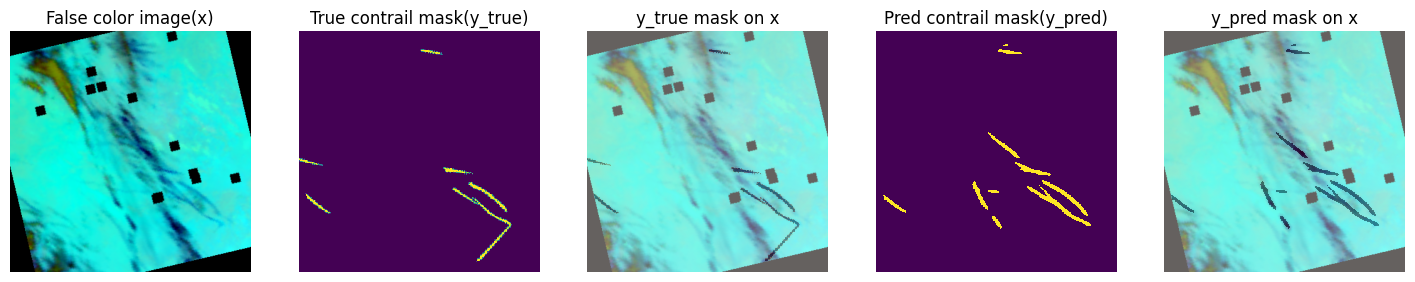

Val Batch: 1/116 | Loss: 0.502083
Val Batch: 101/116 | Loss: 0.434641


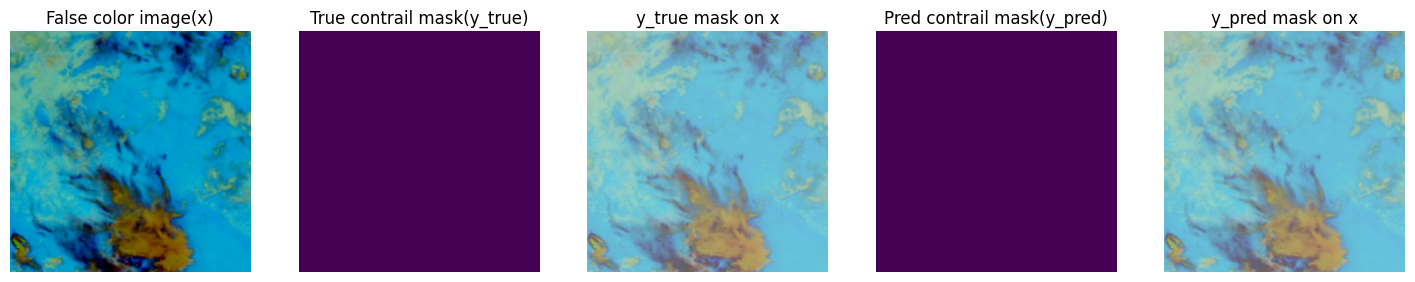

Loss: Train = 0.504170         | Val = 0.531811
Dice: Train = 0.942423         | Val = 0.982549
EPOCH: 3/8, Learning rate: 0.00048249229247759596
Train Batch: 1/1283 | Loss: 0.513519
Train Batch: 101/1283 | Loss: 0.514070
Train Batch: 201/1283 | Loss: 0.471640
Train Batch: 301/1283 | Loss: 0.467363
Train Batch: 401/1283 | Loss: 0.422322
Train Batch: 501/1283 | Loss: 0.433275
Train Batch: 601/1283 | Loss: 0.438981
Train Batch: 701/1283 | Loss: 0.419192
Train Batch: 801/1283 | Loss: 0.513354
Train Batch: 901/1283 | Loss: 0.441183
Train Batch: 1001/1283 | Loss: 0.456986
Train Batch: 1101/1283 | Loss: 0.387705
Train Batch: 1201/1283 | Loss: 0.418279


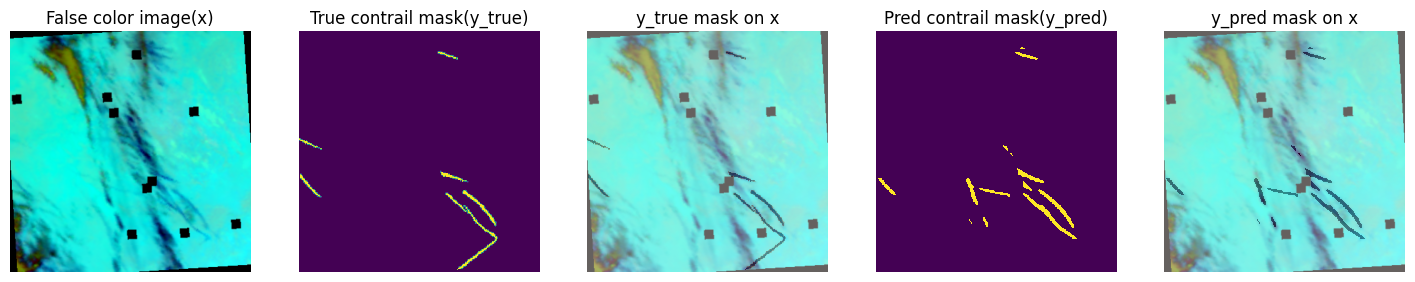

Val Batch: 1/116 | Loss: 0.454677
Val Batch: 101/116 | Loss: 0.404470


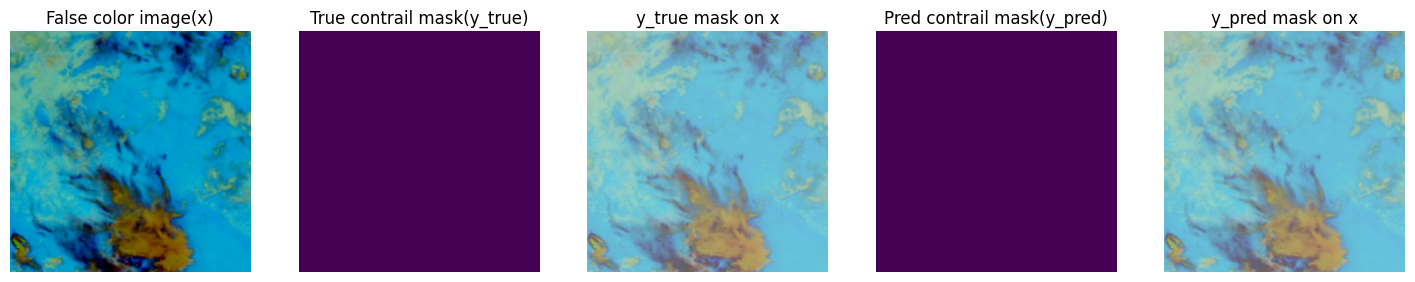

Loss: Train = 0.484991         | Val = 0.511882
Dice: Train = 0.966317         | Val = 1.004928
EPOCH: 4/8, Learning rate: 0.00043263455967290594
Train Batch: 1/1283 | Loss: 0.483491
Train Batch: 101/1283 | Loss: 0.516103
Train Batch: 201/1283 | Loss: 0.496657
Train Batch: 301/1283 | Loss: 0.461586
Train Batch: 401/1283 | Loss: 0.398604
Train Batch: 501/1283 | Loss: 0.455147
Train Batch: 601/1283 | Loss: 0.420050
Train Batch: 701/1283 | Loss: 0.408597
Train Batch: 801/1283 | Loss: 0.492259
Train Batch: 901/1283 | Loss: 0.491838
Train Batch: 1001/1283 | Loss: 0.440334
Train Batch: 1101/1283 | Loss: 0.408469
Train Batch: 1201/1283 | Loss: 0.429684


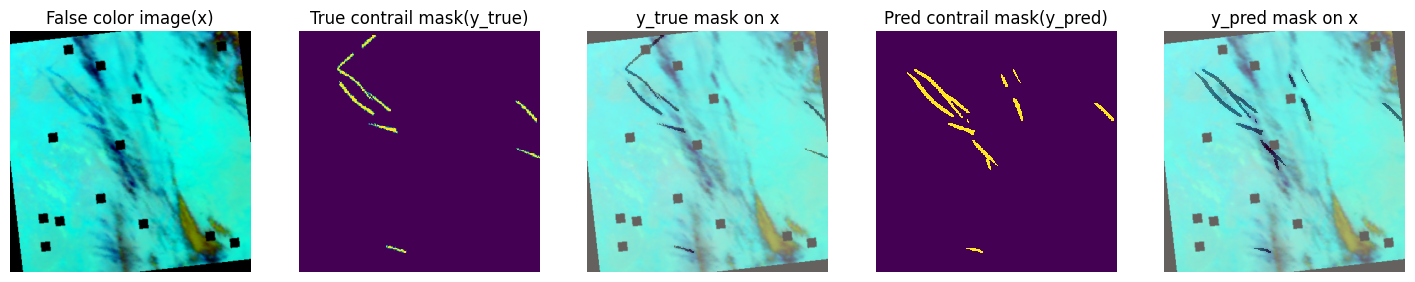

Val Batch: 1/116 | Loss: 0.475978
Val Batch: 101/116 | Loss: 0.408615


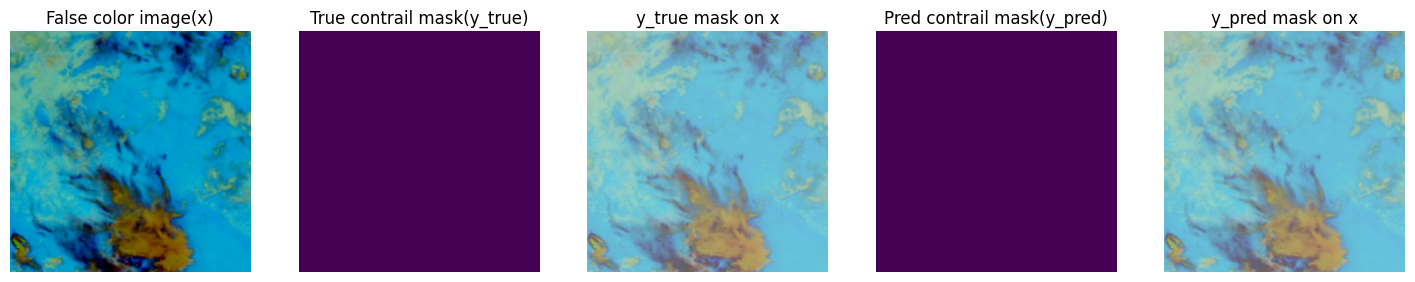

Loss: Train = 0.471183         | Val = 0.513819
Dice: Train = 0.981607         | Val = 1.029106
EPOCH: 5/8, Learning rate: 0.0003580171894439707
Train Batch: 1/1283 | Loss: 0.447849
Train Batch: 101/1283 | Loss: 0.502038
Train Batch: 201/1283 | Loss: 0.489507
Train Batch: 301/1283 | Loss: 0.419569
Train Batch: 401/1283 | Loss: 0.403958
Train Batch: 501/1283 | Loss: 0.456830
Train Batch: 601/1283 | Loss: 0.421442
Train Batch: 701/1283 | Loss: 0.384081
Train Batch: 801/1283 | Loss: 0.508325
Train Batch: 901/1283 | Loss: 0.469533
Train Batch: 1001/1283 | Loss: 0.451742
Train Batch: 1101/1283 | Loss: 0.387590
Train Batch: 1201/1283 | Loss: 0.391532


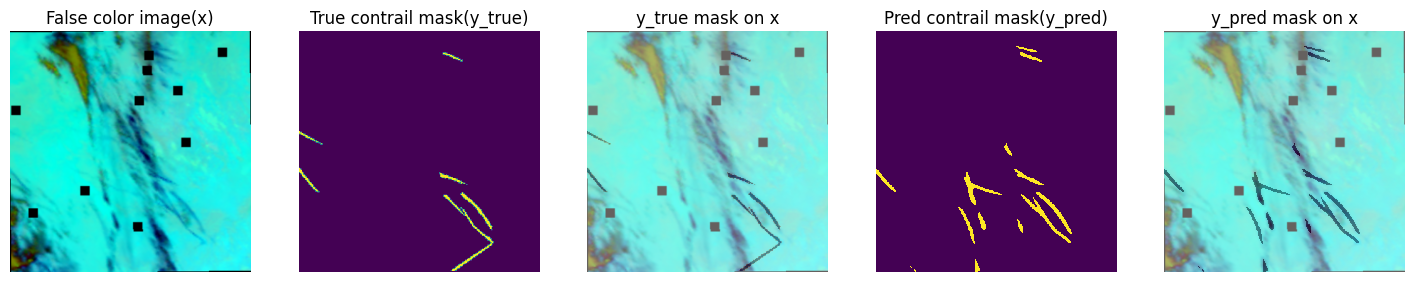

Val Batch: 1/116 | Loss: 0.413605
Val Batch: 101/116 | Loss: 0.433350


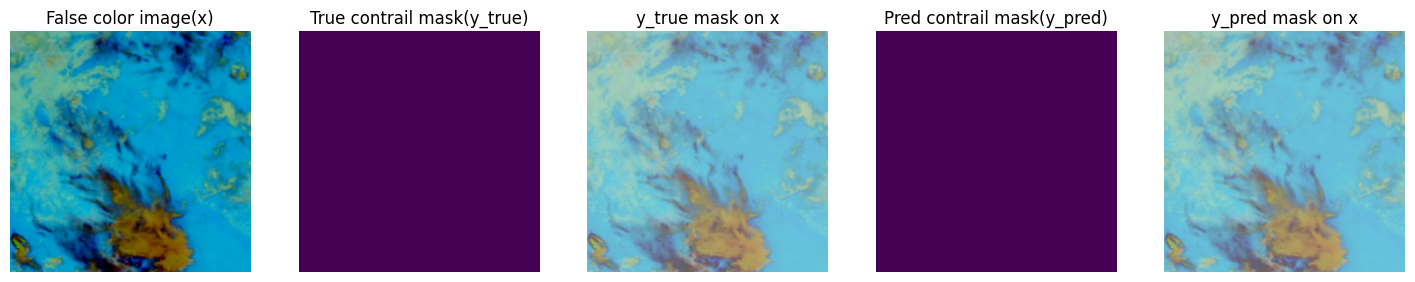

Loss: Train = 0.460160         | Val = 0.501986
Dice: Train = 0.988730         | Val = 0.987418
EPOCH: 6/8, Learning rate: 0.00027
Train Batch: 1/1283 | Loss: 0.465817
Train Batch: 101/1283 | Loss: 0.480082
Train Batch: 201/1283 | Loss: 0.427783
Train Batch: 301/1283 | Loss: 0.417959
Train Batch: 401/1283 | Loss: 0.423825
Train Batch: 501/1283 | Loss: 0.437274
Train Batch: 601/1283 | Loss: 0.425872
Train Batch: 701/1283 | Loss: 0.380181
Train Batch: 801/1283 | Loss: 0.478197
Train Batch: 901/1283 | Loss: 0.400327
Train Batch: 1001/1283 | Loss: 0.407992
Train Batch: 1101/1283 | Loss: 0.365763
Train Batch: 1201/1283 | Loss: 0.416570


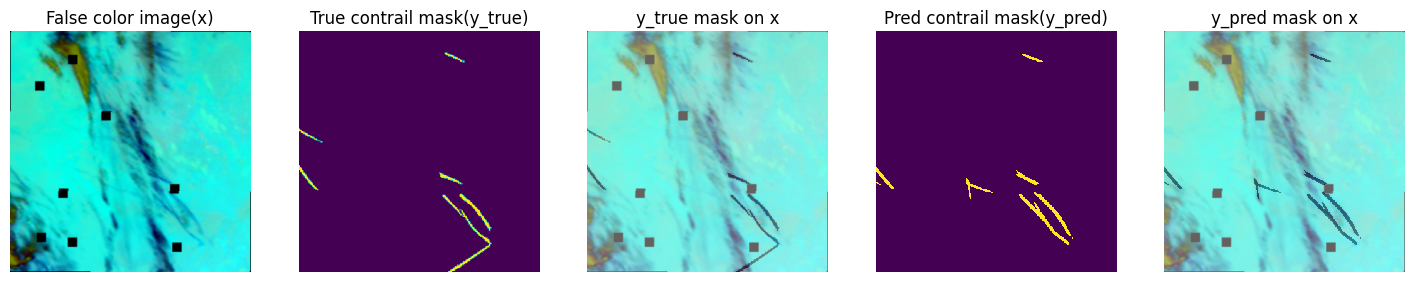

Val Batch: 1/116 | Loss: 0.392761
Val Batch: 101/116 | Loss: 0.369244


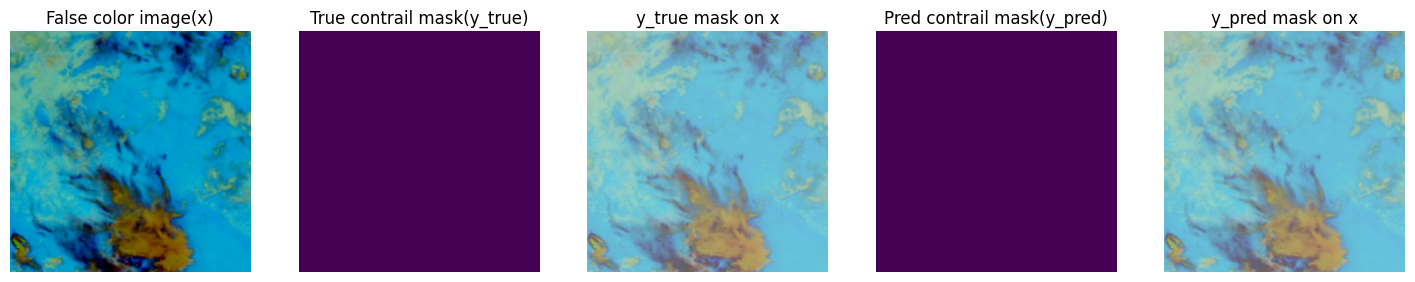

Loss: Train = 0.450276         | Val = 0.466875
Dice: Train = 1.001367         | Val = 0.987627
EPOCH: 7/8, Learning rate: 0.00018198281055602935
Train Batch: 1/1283 | Loss: 0.457278
Train Batch: 101/1283 | Loss: 0.520376
Train Batch: 201/1283 | Loss: 0.441680
Train Batch: 301/1283 | Loss: 0.413158
Train Batch: 401/1283 | Loss: 0.382188
Train Batch: 501/1283 | Loss: 0.434800
Train Batch: 601/1283 | Loss: 0.408061
Train Batch: 701/1283 | Loss: 0.361730
Train Batch: 801/1283 | Loss: 0.478437
Train Batch: 901/1283 | Loss: 0.497358
Train Batch: 1001/1283 | Loss: 0.394899
Train Batch: 1101/1283 | Loss: 0.351772
Train Batch: 1201/1283 | Loss: 0.416077


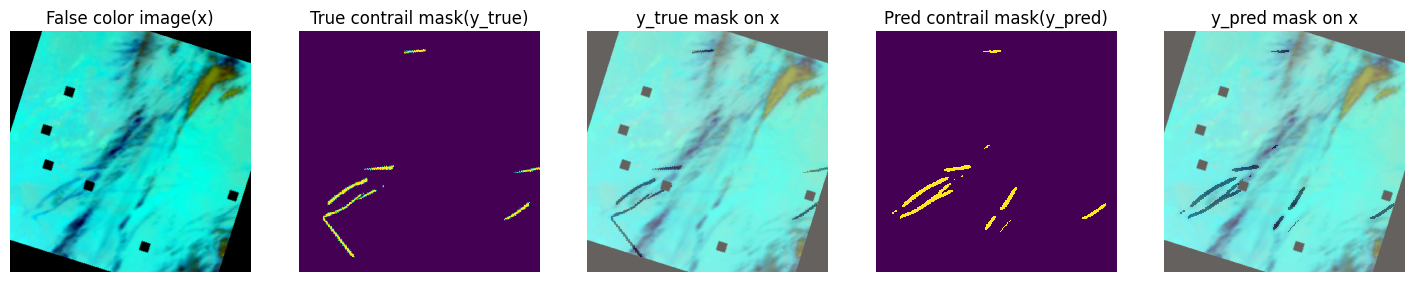

Val Batch: 1/116 | Loss: 0.350378
Val Batch: 101/116 | Loss: 0.364886


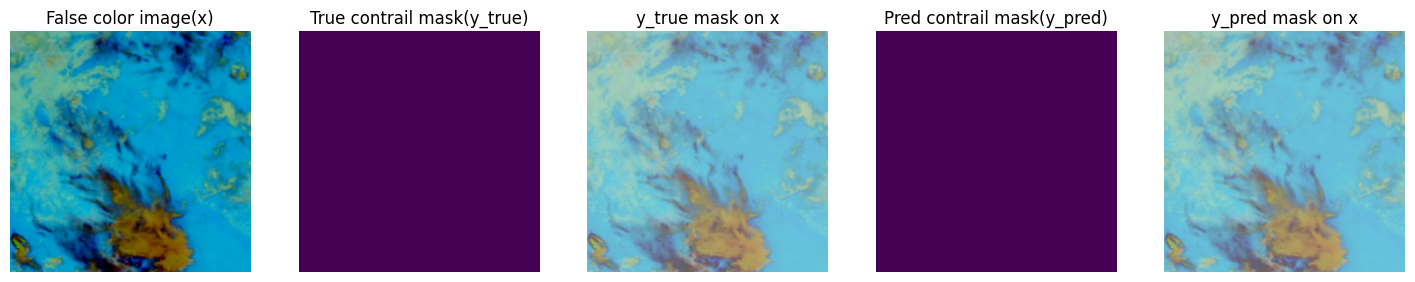

Loss: Train = 0.440439         | Val = 0.471544
Dice: Train = 1.011152         | Val = 1.014686
EPOCH: 8/8, Learning rate: 0.0001073654403270941
Train Batch: 1/1283 | Loss: 0.462942
Train Batch: 101/1283 | Loss: 0.476162
Train Batch: 201/1283 | Loss: 0.418230
Train Batch: 301/1283 | Loss: 0.403790
Train Batch: 401/1283 | Loss: 0.361158
Train Batch: 501/1283 | Loss: 0.414157
Train Batch: 601/1283 | Loss: 0.394258
Train Batch: 701/1283 | Loss: 0.353384
Train Batch: 801/1283 | Loss: 0.445553
Train Batch: 901/1283 | Loss: 0.431528
Train Batch: 1001/1283 | Loss: 0.414397
Train Batch: 1101/1283 | Loss: 0.346928
Train Batch: 1201/1283 | Loss: 0.382935


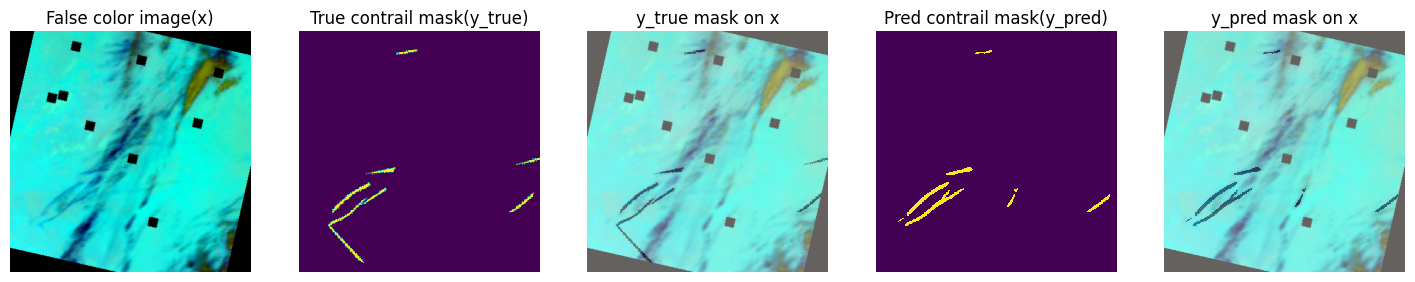

Val Batch: 1/116 | Loss: 0.384398
Val Batch: 101/116 | Loss: 0.326378


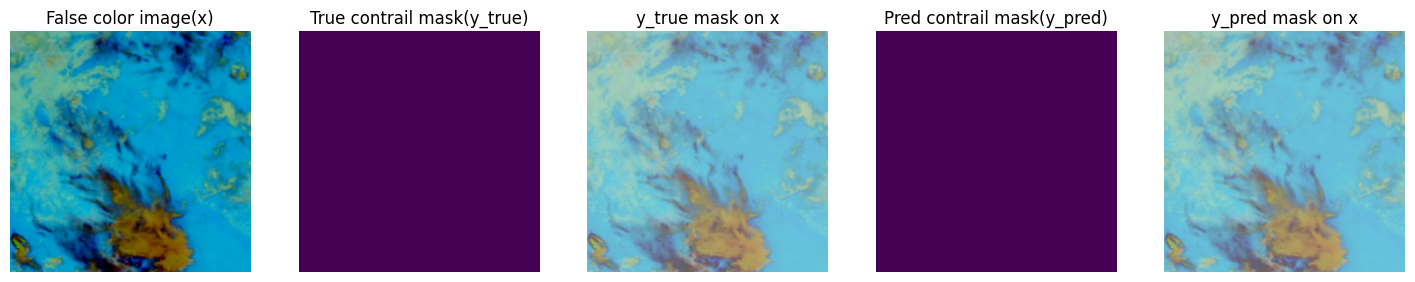

Loss: Train = 0.433148         | Val = 0.459245
Dice: Train = 1.014354         | Val = 1.022670


  0%|          | 0/8 [6:37:10<?, ?it/s]


In [27]:
xmp.spawn(_map_fn, args=(FLAGS,), nprocs=1, start_method='fork')